In [1]:
import os
import glob
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from obspy.signal.cross_correlation import correlate, xcorr_max
import h5py
from scipy.fftpack import hilbert
from scipy.signal import  iirfilter
from scipy.signal import sosfilt
from scipy.signal import zpk2sos, windows

In [2]:
def bandpass(data, freqmin, freqmax, df, corners=4, zerophase=True):
    """
    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freqmin: Pass band low corner frequency.
    :param freqmax: Pass band high corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the filter order but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    z, p, k = iirfilter(corners, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)    

In [28]:
# The path to your file
fpath = glob.glob(r"C:\Users\obandohe\OneDrive - Stichting Deltares\Documents\DELTARES_PROJECTS\2024\17_PRORAIL_CTS_ADVISORY\*.h5")

path_ = fpath[1]
# Open the file for reading
fp = h5py.File(path_,'r')

# Print the values associated with some important attributes
print('\nThe gauge length is ',fp['Acquisition'].attrs['GaugeLength'],'m.')
print('The pulse rate is ',fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'],'Hz.')
print('The pulse rate is ',fp['Acquisition'].attrs['PulseRate'],'Hz.')
print('The spatial sampling interval is ',fp['Acquisition'].attrs['SpatialSamplingInterval'],'m.')

fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']

# Create a new variable for the "RawData" h5py dataset
rawData = fp['Acquisition']['Raw[0]']['RawData']

signals = rawData[:]

window = windows.tukey(60000,0.1)

filt_array = np.zeros(np.shape(signals))

for i in range(3000):

    signal_filt = bandpass(window*signals[:,i], 1.0, 50, fs, corners=5, zerophase=True)
    filt_array[:,i] = signal_filt




The gauge length is  10.209524 m.
The pulse rate is  1000.0 Hz.
The pulse rate is  5000.0 Hz.
The spatial sampling interval is  1.0209523 m.


C:\Users\obandohe\AppData\Local\Temp\ipykernel_9748\496360002.py:3: RuntimeWarning: divide by zero encountered in log10
  cbar0 = ax0.imshow(np.log10(np.abs(signals)),aspect='auto',cmap='jet')


Text(0.5, 1.0, 'FILTERD -- 1 Hz - 50 Hzsensor_2024-08-29T080549Z.h5')

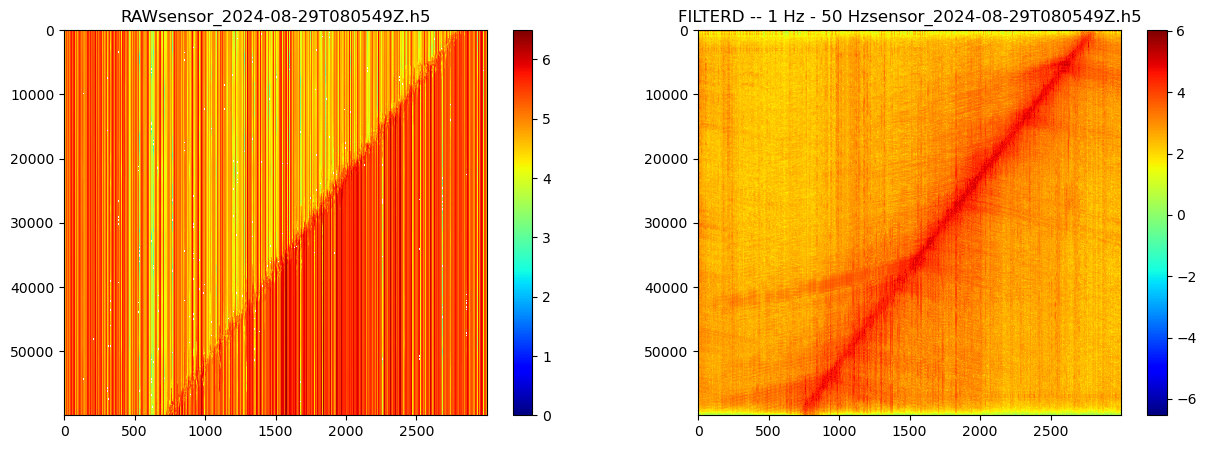

In [34]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15,5))

cbar0 = ax0.imshow(np.log10(np.abs(signals)),aspect='auto',cmap='jet')
fig.colorbar(cbar0, ax=ax0)
ax0.set_title('RAW' + path_[-28:])
cbar1 = ax1.imshow(np.log10(np.abs(filt_array)),aspect='auto',cmap='jet')
fig.colorbar(cbar1, ax=ax1)
ax1.set_title('FILTERD -- 1 Hz - 50 Hz'+path_[-28:])

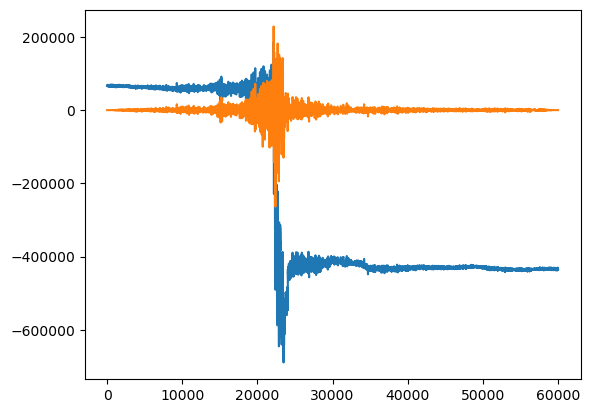

In [31]:
plt.plot(signals[:,2000])
plt.plot(filt_array[:,2000])
plt.title('Trace 2000')